# Part 3 Snowpack Creation and Analysis
[Benoit Montpetit](https://github.com/ecccben), *CPS/CRD/ECCC*, 2024  
[Josh King](https://github.com/kingjml), *CPS/CRD/ECCC*, 2021  
[Mike Brady](https://github.com/m9brady), *CPS/CRD/ECCC*, 2024

In this notebook we generate snowpack representations based on snow pit observations and SMP profiles.

In [3]:
# Community imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
plt.rcParams["axes.labelsize"] = 22
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16


# ECCC imports
from snowpit_datasheet_parser import SnowPitSheet
import smpfunc
import tvcfunc
import radarfunc
import constants

# Import snow data and coeffs from previous steps
pit_meta = pd.read_pickle(r"Data/ref_pit.pkl")
pit_stats = pd.read_pickle(r"Data/pit_stats.pkl")
smp_meta = pd.read_pickle(r"Data/smp_meta.pkl")
ref_ssa =  pd.read_pickle(r"Data/ref_ssa.pkl")
ref_dens = pd.read_pickle(r"Data/ref_rho.pkl")
ref_temp = pd.read_pickle(r"Data/ref_temp.pkl")
ref_mp = pd.read_pickle(r"Data/ref_mp.pkl")
smp_dens_train = pd.read_pickle(r"Data/Scaled_SMP_dens.pkl")
smp_ssa_train = pd.read_pickle(r"Data/Scaled_SMP_ssa.pkl")

SSA_COEFFS = np.load(r'Data/ssa_ols_coeffs.npy')
RHO_COEFFS = np.load(r'Data/density_ols_coeffs.npy')

# Processing constants
SMRT_PHI = 1 # Microstructure scaling constant

# Generate snowpack parameterizations for SMRT
Generate standard snow pit data using the available field data at each of the sites:
1. Snow pit stratigraphy (n-layer)
2. SMP profiles (n-layer layer)

First we standardize our measurements of varried resolution into layers observed in the snow pits. We do this to avoide excessive layer complexity that might introduce errors (i.e [Sandells et. al. 2020](https://ieeexplore.ieee.org/ielx7/36/9633014/09455876.pdf?tag=1)). Each snow pit is then in turn refactored into SMRT snowpack objects. This requires conversion of the pit observed SSA into correlation length.

In [4]:
pit_input = pd.DataFrame()
smrt_phi = 1
for c_idx, c_pit in pit_meta.iterrows():
    std_pit = tvcfunc.standardize_pit(SnowPitSheet(c_pit['file_path']),
                              ref_ssa.loc[ref_ssa['site'] == c_pit['pit_id'].replace('RP', 'RS')],
                              ref_dens.loc[ref_dens['site'] == c_pit['pit_id'].replace('RP', 'RS')],
                              ref_temp.loc[ref_temp['site'] == c_pit['pit_id'].replace('RP', 'RS')])
    
    smrt_pit = radarfunc.pit_to_smrt(std_pit, phi_corr=smrt_phi, return_df = False)
    
    pit_input = pd.concat([pit_input,pd.DataFrame({'site': [c_pit['site']],
                                  'campaign': [c_pit['campaign']],
                                  'pit_id': [c_pit['pit_id']],
                                  'timestamp': [c_pit['timestamp']],
                                  'layers_pit': [len(std_pit)],
                                  'std_pit': [std_pit],
                                  'smrt_pit': [smrt_pit],
                                  'smrt_phi': [smrt_phi]})],
                                   ignore_index=True)

Text(0, 0.5, 'Height above surface (m)')

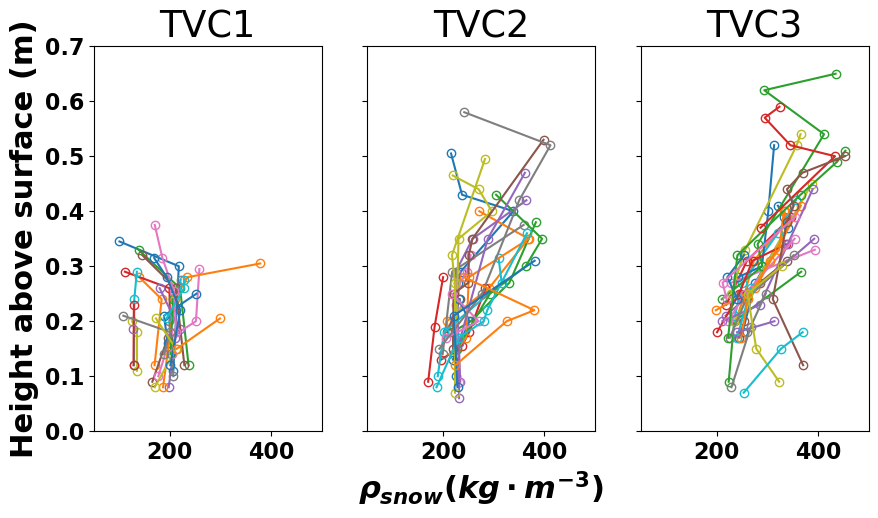

In [5]:
# Snow pit density by campaign
fig, axs = plt.subplots(1, 3, sharey = True, figsize=(10,5))
dens_lim = [50, 500]

axs[0].set_ylim(0, 0.7)
axs[0].set_xlim(dens_lim[0], dens_lim[1])
axs[1].set_xlim(dens_lim[0], dens_lim[1])
axs[2].set_xlim(dens_lim[0], dens_lim[1])

for tvc_idx, tvc_campaign in enumerate([constants.TVC01,constants.TVC02,constants.TVC03]):
    pits_c = pit_input[pit_input['site'].isin(tvc_campaign)]['std_pit']
    axs[tvc_idx].set_title('TVC' + str(tvc_idx+1))
    for pit in pits_c:
        axs[tvc_idx].plot(pit['density'], pit['l_height_top'], 
                          marker = 'o', fillstyle = 'none')
        
axs[1].set_xlabel('$\\rho_{snow} (kg \\cdot m^{-3})$')
axs[0].set_ylabel('Height above surface (m)')

<center><img src="Figures/Part_3_Snowpack_ETL_Fig1.png.png" height="500px"></center>

<center>Figure: Measured density profiles per intensive campaign in November (TVC1), January (TVC2) and March (TVC3).</center>

Text(0, 0.5, 'Height above surface (m)')

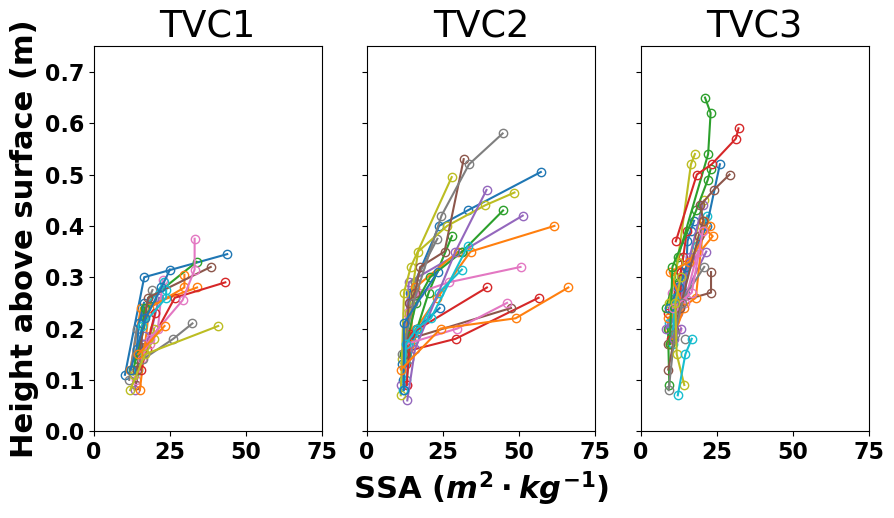

In [6]:
# Snow pit SSA by campaign
fig, axs = plt.subplots(1, 3, sharey = True, figsize=(10,5))
ssa_lim = [0, 75]

axs[0].set_ylim(0, 0.75)
axs[0].set_xlim(ssa_lim[0], ssa_lim[1])
axs[1].set_xlim(ssa_lim[0], ssa_lim[1])
axs[2].set_xlim(ssa_lim[0], ssa_lim[1])

for tvc_idx, tvc_campaign in enumerate([constants.TVC01,constants.TVC02,constants.TVC03]):
    pits_c = pit_input[pit_input['site'].isin(tvc_campaign)]['std_pit']
    axs[tvc_idx].set_title('TVC' + str(tvc_idx+1))
    for pit in pits_c:
        axs[tvc_idx].plot(pit['ssa'], pit['l_height_top'], 
                          marker = 'o', fillstyle = 'none')
        
axs[1].set_xlabel('SSA ($m^2 \\cdot kg^{-1}$)')
axs[0].set_ylabel('Height above surface (m)')

<center><img src="Figures/Part_3_Snowpack_ETL_Fig2.png.png" height="500px"></center>

<center>Figure: Measured SSA profiles per intensive campaign in November (TVC1), January (TVC2) and March (TVC3).</center>

In [7]:
############ Outputs
pit_input.to_pickle(r"Data/model_pit_input.pkl")

In [8]:
pit_input.loc[pit_input['pit_id'] == 'SM02']

,site,campaign,pit_id,timestamp,layers_pit,std_pit,smrt_pit,smrt_phi
62,SM02,TVC02,SM02,2019-01-11 15:54:00,4,l_height_top thickness grain_type dens...,Snowpack: layer ...,1


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>site</th>
      <th>campaign</th>
      <th>pit_id</th>
      <th>timestamp</th>
      <th>layers_pit</th>
      <th>std_pit</th>
      <th>smrt_pit</th>
      <th>smrt_phi</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>62</th>
      <td>SM02</td>
      <td>TVC02</td>
      <td>SM02</td>
      <td>2019-01-11 15:54:00</td>
      <td>4</td>
      <td>l_height_top  thickness grain_type     dens...</td>
      <td>Snowpack:       layer                         ...</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

In [9]:
pit_input.loc[pit_input['pit_id'] == 'SM02']['std_pit'].values[0]

,l_height_top,thickness,grain_type,density,ssa,temperature,vol_frac,d0,p_ex
0,0.495,0.175,M,282.593750,27.809591,246.881812,0.308172,0.000235,0.000109
1,0.320,0.050,H,217.302632,14.334457,249.520901,0.236971,0.000456,0.000232
2,0.270,0.200,H,223.332410,12.110540,256.204769,0.243547,0.000540,0.000272
3,0.070,0.070,H,223.332410,11.056540,262.208754,0.243547,0.000592,0.000298


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>l_height_top</th>
      <th>thickness</th>
      <th>grain_type</th>
      <th>density</th>
      <th>ssa</th>
      <th>temperature</th>
      <th>vol_frac</th>
      <th>d0</th>
      <th>p_ex</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.495</td>
      <td>0.175</td>
      <td>M</td>
      <td>282.593750</td>
      <td>27.809591</td>
      <td>246.881812</td>
      <td>0.308172</td>
      <td>0.000235</td>
      <td>0.000109</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.320</td>
      <td>0.050</td>
      <td>H</td>
      <td>217.302632</td>
      <td>14.334457</td>
      <td>249.520901</td>
      <td>0.236971</td>
      <td>0.000456</td>
      <td>0.000232</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.270</td>
      <td>0.200</td>
      <td>H</td>
      <td>223.332410</td>
      <td>12.110540</td>
      <td>256.204769</td>
      <td>0.243547</td>
      <td>0.000540</td>
      <td>0.000272</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.070</td>
      <td>0.070</td>
      <td>H</td>
      <td>223.332410</td>
      <td>11.056540</td>
      <td>262.208754</td>
      <td>0.243547</td>
      <td>0.000592</td>
      <td>0.000298</td>
    </tr>
  </tbody>
</table>
</div>

# SMP Derived Pits

Use the previous calibration of the SMP to generate profiles of SSA, correlation length, and density.

1. Iterate through the site based data

In [10]:
site ='SM02'

smp_df = smp_meta.loc[smp_meta['site'] == site].reset_index()
smp_data = [smpfunc.load_smp_data(smp_file, constants.WINDOW_SIZE) for smp_file in smp_df['path'].tolist()]

Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


In [11]:
smp_df

,index,position,file,probe,pen,notes,site,path
0,1177,RHO,2888,50.0,50.0,NaN,SM02,Data\Site\SM02\S34M2888.pnt
1,1178,SSA,2889,50.0,50.0,NaN,SM02,Data\Site\SM02\S34M2889.pnt
2,1179,N1,2870,48.0,50.0,GPS,SM02,Data\Site\SM02\S34M2870.pnt
3,1180,N2,2871,59.0,60.0,NaN,SM02,Data\Site\SM02\S34M2871.pnt
4,1181,N3,2872,40.0,40.0,NaN,SM02,Data\Site\SM02\S34M2872.pnt
5,1182,N4,2874,53.0,53.0,NaN,SM02,Data\Site\SM02\S34M2874.pnt
6,1183,N5,2875,52.0,52.0,NaN,SM02,Data\Site\SM02\S34M2875.pnt
7,1184,E1,2876,50.0,50.0,GPS,SM02,Data\Site\SM02\S34M2876.pnt
8,1185,E2,2877,44.0,50.0,GND,SM02,Data\Site\SM02\S34M2877.pnt
9,1186,E3,2878,70.0,70.0,GPS,SM02,Data\Site\SM02\S34M2878.pnt


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>index</th>
      <th>position</th>
      <th>file</th>
      <th>probe</th>
      <th>pen</th>
      <th>notes</th>
      <th>site</th>
      <th>path</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1177</td>
      <td>RHO</td>
      <td>2888</td>
      <td>50.0</td>
      <td>50.0</td>
      <td>NaN</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2888.pnt</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1178</td>
      <td>SSA</td>
      <td>2889</td>
      <td>50.0</td>
      <td>50.0</td>
      <td>NaN</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2889.pnt</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1179</td>
      <td>N1</td>
      <td>2870</td>
      <td>48.0</td>
      <td>50.0</td>
      <td>GPS</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2870.pnt</td>
    </tr>
    <tr>
      <th>3</th>
      <td>1180</td>
      <td>N2</td>
      <td>2871</td>
      <td>59.0</td>
      <td>60.0</td>
      <td>NaN</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2871.pnt</td>
    </tr>
    <tr>
      <th>4</th>
      <td>1181</td>
      <td>N3</td>
      <td>2872</td>
      <td>40.0</td>
      <td>40.0</td>
      <td>NaN</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2872.pnt</td>
    </tr>
    <tr>
      <th>5</th>
      <td>1182</td>
      <td>N4</td>
      <td>2874</td>
      <td>53.0</td>
      <td>53.0</td>
      <td>NaN</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2874.pnt</td>
    </tr>
    <tr>
      <th>6</th>
      <td>1183</td>
      <td>N5</td>
      <td>2875</td>
      <td>52.0</td>
      <td>52.0</td>
      <td>NaN</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2875.pnt</td>
    </tr>
    <tr>
      <th>7</th>
      <td>1184</td>
      <td>E1</td>
      <td>2876</td>
      <td>50.0</td>
      <td>50.0</td>
      <td>GPS</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2876.pnt</td>
    </tr>
    <tr>
      <th>8</th>
      <td>1185</td>
      <td>E2</td>
      <td>2877</td>
      <td>44.0</td>
      <td>50.0</td>
      <td>GND</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2877.pnt</td>
    </tr>
    <tr>
      <th>9</th>
      <td>1186</td>
      <td>E3</td>
      <td>2878</td>
      <td>70.0</td>
      <td>70.0</td>
      <td>GPS</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2878.pnt</td>
    </tr>
    <tr>
      <th>10</th>
      <td>1187</td>
      <td>W1</td>
      <td>2879</td>
      <td>55.0</td>
      <td>60.0</td>
      <td>GND</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2879.pnt</td>
    </tr>
    <tr>
      <th>11</th>
      <td>1188</td>
      <td>W2</td>
      <td>2880</td>
      <td>56.0</td>
      <td>60.0</td>
      <td>GND</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2880.pnt</td>
    </tr>
    <tr>
      <th>12</th>
      <td>1189</td>
      <td>W3</td>
      <td>2881</td>
      <td>41.0</td>
      <td>45.0</td>
      <td>NaN</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2881.pnt</td>
    </tr>
    <tr>
      <th>13</th>
      <td>1190</td>
      <td>S1</td>
      <td>2882</td>
      <td>44.0</td>
      <td>50.0</td>
      <td>GND</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2882.pnt</td>
    </tr>
    <tr>
      <th>14</th>
      <td>1191</td>
      <td>S2</td>
      <td>2883</td>
      <td>40.0</td>
      <td>45.0</td>
      <td>GND</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2883.pnt</td>
    </tr>
    <tr>
      <th>15</th>
      <td>1192</td>
      <td>S3</td>
      <td>2884</td>
      <td>60.0</td>
      <td>65.0</td>
      <td>GND</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2884.pnt</td>
    </tr>
    <tr>
      <th>16</th>
      <td>1193</td>
      <td>S4</td>
      <td>2886</td>
      <td>35.0</td>
      <td>35.0</td>
      <td>GND</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2886.pnt</td>
    </tr>
    <tr>
      <th>17</th>
      <td>1194</td>
      <td>S5</td>
      <td>2887</td>
      <td>58.0</td>
      <td>60.0</td>
      <td>NaN</td>
      <td>SM02</td>
      <td>Data\Site\SM02\S34M2887.pnt</td>
    </tr>
  </tbody>
</table>
</div>

In [12]:
smp_data[0]

,rel_height,force_median,lambda,f0,delta,l
0,0.0,0.059195,3838.503803,0.001199,0.025948,0.172302
1,2.5,0.053934,1177.964090,0.002498,0.036092,0.255446
2,5.0,0.040779,1707.174249,0.002143,0.022548,0.225727
3,7.5,0.034202,2710.573051,0.001480,0.016758,0.193489
4,10.0,0.030255,3707.476374,0.001192,0.013895,0.174308
...,...,...,...,...,...,...
162,405.0,7.812476,332.906276,0.372871,0.127906,0.389257
163,407.5,8.247233,115.636743,0.563105,0.257827,0.553747
164,410.0,8.078855,89.341824,0.665588,0.275264,0.603474
165,412.5,6.279315,170.063524,0.895576,0.089839,0.486937


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>rel_height</th>
      <th>force_median</th>
      <th>lambda</th>
      <th>f0</th>
      <th>delta</th>
      <th>l</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.0</td>
      <td>0.059195</td>
      <td>3838.503803</td>
      <td>0.001199</td>
      <td>0.025948</td>
      <td>0.172302</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2.5</td>
      <td>0.053934</td>
      <td>1177.964090</td>
      <td>0.002498</td>
      <td>0.036092</td>
      <td>0.255446</td>
    </tr>
    <tr>
      <th>2</th>
      <td>5.0</td>
      <td>0.040779</td>
      <td>1707.174249</td>
      <td>0.002143</td>
      <td>0.022548</td>
      <td>0.225727</td>
    </tr>
    <tr>
      <th>3</th>
      <td>7.5</td>
      <td>0.034202</td>
      <td>2710.573051</td>
      <td>0.001480</td>
      <td>0.016758</td>
      <td>0.193489</td>
    </tr>
    <tr>
      <th>4</th>
      <td>10.0</td>
      <td>0.030255</td>
      <td>3707.476374</td>
      <td>0.001192</td>
      <td>0.013895</td>
      <td>0.174308</td>
    </tr>
    <tr>
      <th>...</th>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    <tr>
      <th>162</th>
      <td>405.0</td>
      <td>7.812476</td>
      <td>332.906276</td>
      <td>0.372871</td>
      <td>0.127906</td>
      <td>0.389257</td>
    </tr>
    <tr>
      <th>163</th>
      <td>407.5</td>
      <td>8.247233</td>
      <td>115.636743</td>
      <td>0.563105</td>
      <td>0.257827</td>
      <td>0.553747</td>
    </tr>
    <tr>
      <th>164</th>
      <td>410.0</td>
      <td>8.078855</td>
      <td>89.341824</td>
      <td>0.665588</td>
      <td>0.275264</td>
      <td>0.603474</td>
    </tr>
    <tr>
      <th>165</th>
      <td>412.5</td>
      <td>6.279315</td>
      <td>170.063524</td>
      <td>0.895576</td>
      <td>0.089839</td>
      <td>0.486937</td>
    </tr>
    <tr>
      <th>166</th>
      <td>415.0</td>
      <td>6.070816</td>
      <td>222.972228</td>
      <td>0.414305</td>
      <td>0.134226</td>
      <td>0.444897</td>
    </tr>
  </tbody>
</table>
<p>167 rows × 6 columns</p>
</div>

In [13]:
smp_result = pd.DataFrame()
for smp_site in smp_meta['site'].unique():
    smp_df = smp_meta.loc[smp_meta['site'] == smp_site].reset_index()
    print(smp_site + ': ' + str(len(smp_df)))
    pos_names = smp_df['position'].values
    smp_density = [];smp_ssa = []
    for smp_file in smp_df['path'].tolist():
        try:
            smp_data = smpfunc.load_smp_data(smp_file, constants.WINDOW_SIZE)
            smp_density.append(smpfunc.calc_density(smp_data, RHO_COEFFS, True))
            smp_ssa.append(smpfunc.calc_ssa_loglog(smp_data, SSA_COEFFS, True))
        except:
            smp_density.append(np.nan)
            smp_ssa.append(np.nan)
    pos_names = smp_df['position'].values
    smp_site_result = pd.DataFrame({'site': np.repeat(smp_site, len(pos_names)),
                           'position': pos_names,
                            'density': smp_density,
                            'ssa': smp_ssa})
    smp_result = pd.concat([smp_result,smp_site_result], ignore_index=True)
smp_result = smp_result.dropna(subset=['density', 'ssa'])

RS01: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS02: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


RS03: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS04: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: Runt

RS05: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS06: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS07: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS08: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS09: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS10: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS11: 18
RS12: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS13: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS14: 18
RS15: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS16: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS17: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS18: 18
RS19: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS20: 18


C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replac

RS21: 18


C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


RS22: 18


C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


RS23: 18
RS24: 18
RS25: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS26: 17


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS27: 18


C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


RS28: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS29: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS30: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS31: 18
RS32: 19


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS33: 19


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS34: 19
RS35: 21
RS36: 18
RS37: 19


C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


RS38: 22
RS39: 19


C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


RS40: 22


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS41: 21


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


RS42: 21
RS43: 22


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS44: 22
RS45: 22
RS46: 22


C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


RS47: 21


Latitude value -99999.0 invalid, replacing by None


RS48: 18


Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS49: 21
RS50: 19
RS51: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS52: 21


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


RS53: 24


C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


RS54: 21


C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


RS55: 21
SC01: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


SC02: 18
SC03: 19
SD01: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


SD02: 16


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


SD03: 21
SM01: 18
SM02: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


SM03: 21
SO01: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


SO02: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


SO03: 19


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


SR01: 4
ST01: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


ST02: 18


C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity
Failed to detect surface
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


ST03: 19


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


SV01: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


SV02: 18


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


SV03: 20


C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:58: RuntimeWarning: invalid value encountered in scalar divide
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res
C:\Users\MontpetitB\Documents\Git\snowmicropyn\snowmicropyn\loewe2012.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  lambda_ = (4. / 3) * (k1 ** 2) / k2 / delta  # Intensity


In [14]:
smp_result.to_pickle(r"Data/smp_result.pkl")

# Site example of snow pit comparision issue  

This shows that measurements taken at the snowpit is not representative of the satellite scale measurement (100m scale in this study). This is why SMP profiles need to be measured within a given footprint to better represent the snowpack variability at that scale.

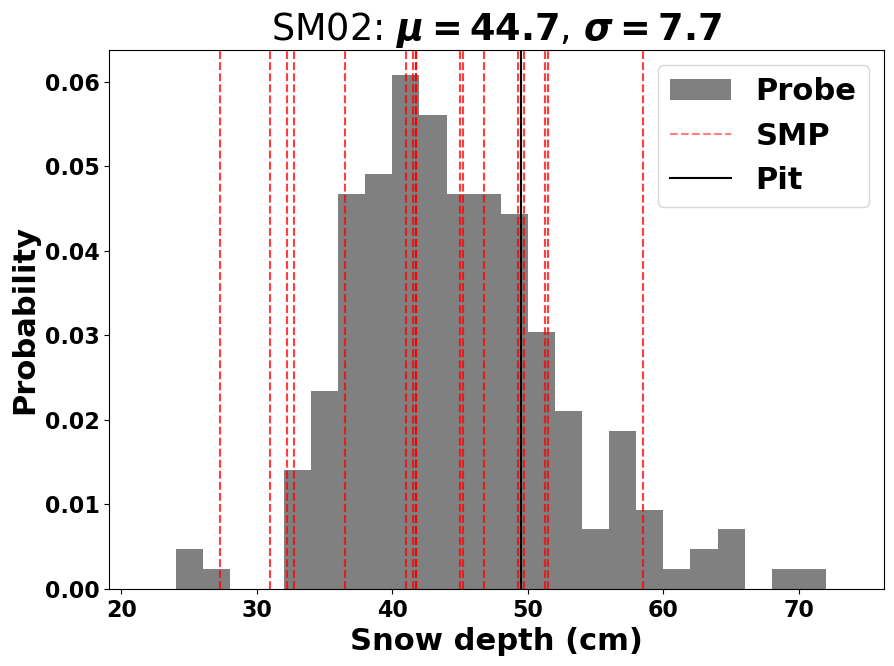

In [15]:
site_name = 'SM02'
site_mp = ref_mp.loc[ref_mp['site'] == site_name]

fig, ax = plt.subplots(figsize=(10,7))
bins = np.arange(0,100,2)
mu = site_mp.depth.mean()  # mean of distribution
sigma = site_mp.depth.std() 
n, bins, patches = ax.hist(site_mp.depth, bins = bins, density=True, color = 'grey', alpha = 1, label="Probe")

ax.set_xlim(mu-sigma*3, mu+sigma*3)

for site in smp_result.loc[smp_result.site==site_name].position.values:
    ax.axvline(x=smp_result.loc[(smp_result.site==site_name) & (smp_result.position==site)].iloc[0].density.rel_height.max()/10, 
               color = 'red', alpha = 0.5, linestyle='--', label = 'SMP')
    ax.axvline(x=smp_result.loc[(smp_result.site==site_name) & (smp_result.position==site)].iloc[0].density.rel_height.max()/10, 
               color = 'red', alpha = 0.5, linestyle='--', label = 'SMP')
    
ax.axvline(x=pit_meta[pit_meta['site']==site_name]['total_depth'].values[0], color = 'k', label = 'Pit')
ax.set_xlim(site_mp.depth.min()-5, site_mp.depth.max()+5)

ax.set_title('%s: $\mu=%.1f$, $\sigma = %.1f$' %(site_name, round(mu,1),round(sigma,1)))
ax.set_xlabel('Snow depth (cm)')
ax.set_ylabel('Probability')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

<center><img src="Figures/Part_3_Snowpack_ETL_Fig3.png" height="500px"></center>

<center>Figure: Comparison between the Magnaprobe snow depth distributions (Probe), the SMP snow depth measured (SMP) and the measured snow depth at the snowpit wall (Pit).</center>